# Project

### Github Repository: https://github.com/jecciii/DSCI100-Project

## Introduction

### Background
Video games have become an increasingly important platform in our recent world. In academic settings, multiplayer games like Minecraft offer a controlled yet dynamic environment where player behavior can be observed in detail. A research group at the University of British Columbia has launched a dedicated Minecraft server to collect such data, aiming to better understand how players interact with the game world and with each other.
In this project, we focus on one specific variable: newsletter subscription. Subscribing to a game-related newsletter may indicate greater player engagement, curiosity about project updates, or willingness to participate in ongoing research. Understanding which player characteristics and behaviors are associated with newsletter subscriptions can help researchers improve in-game experiences, and allocate resources more effectively.

### Question
Can play time and experience level predict newsletter subscription in the Minecraft players.csv dataset?

### Data Description
This project uses the `players.csv` dataset from UBC provided. Each row represents a unique player and includes information such as total hours played (`played_hours`), experience level (`experience`), `age`, `gender`, and whether they subscribed to the newsletter (`subscribe`). The response variable in our classification task is subscribe, which indicates if the player signed up for the newsletter. The primary explanatory variable is `played_hours`, representing the total time a player has spent in the game. Other columns like `name` and `hashedEmail` are excluded from analysis due to  irrelevance. This dataset allows us to explore whether play time alone is a meaningful predictor of newsletter subscription. Rows with missing or invalid values will be removed during data cleaning.

## Methods & Results

In [32]:
library(tidyverse)
library(tidymodels)
library(tune)

In [33]:
player <- read_csv("players.csv")
head (player)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [34]:
clean_player <- player|> 
                select(subscribe, played_hours, experience) |>  
                filter(!is.na(subscribe), !is.na(played_hours), !is.na(experience)) |>
                mutate(subscribe = as_factor(subscribe),experience = as_factor(experience))

head(clean_player)

subscribe,played_hours,experience
<fct>,<dbl>,<fct>
TRUE,30.3,Pro
TRUE,3.8,Veteran
FALSE,0.0,Veteran
TRUE,0.7,Amateur
TRUE,0.1,Regular
TRUE,0.0,Amateur


In [44]:
summary(clean_player)

 subscribe    played_hours        experience
 FALSE: 52   Min.   :  0.000   Pro     :14  
 TRUE :144   1st Qu.:  0.000   Veteran :48  
             Median :  0.100   Amateur :63  
             Mean   :  5.846   Regular :36  
             3rd Qu.:  0.600   Beginner:35  
             Max.   :223.100                

In [45]:
set.seed(1234) 
player_split <- initial_split(clean_player, prop = 0.8, strata = subscribe)
player_training <- training(player_split)
player_testing <- testing(player_split)

In [46]:
knn_model <- nearest_neighbor(neighbors = 5, weight_func = "rectangular") |>
             set_engine("kknn") |>
             set_mode("classification")

In [47]:
knn_fit <- fit(knn_model, subscribe ~ played_hours + experience, data = player_training)
knn_fit

parsnip model object


Call:
kknn::train.kknn(formula = subscribe ~ played_hours + experience,     data = data, ks = min_rows(5, data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3782051
Best kernel: rectangular
Best k: 5

In [54]:
knn_predictions <- predict(knn_fit, player_testing) |>
                   bind_cols(player_testing)
head(knn_predictions)
summary(knn_predictions)

.pred_class,subscribe,played_hours,experience
<fct>,<fct>,<dbl>,<fct>
TRUE,TRUE,30.3,Pro
FALSE,FALSE,0.0,Veteran
TRUE,TRUE,0.1,Regular
FALSE,TRUE,0.0,Amateur
TRUE,TRUE,0.2,Amateur
FALSE,TRUE,0.0,Veteran


 .pred_class subscribe   played_hours       experience
 FALSE:22    FALSE:11   Min.   :  0.00   Pro     : 1  
 TRUE :18    TRUE :29   1st Qu.:  0.00   Veteran :12  
                        Median :  0.10   Amateur :12  
                        Mean   :  8.52   Regular : 9  
                        3rd Qu.:  1.35   Beginner: 6  
                        Max.   :223.10                

In [55]:
metrics(knn_predictions, truth = subscribe, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.475000000
kap,binary,-0.004784689


In [56]:
conf_mat(knn_predictions, truth = subscribe, estimate = .pred_class)

          Truth
Prediction FALSE TRUE
     FALSE     6   16
     TRUE      5   13

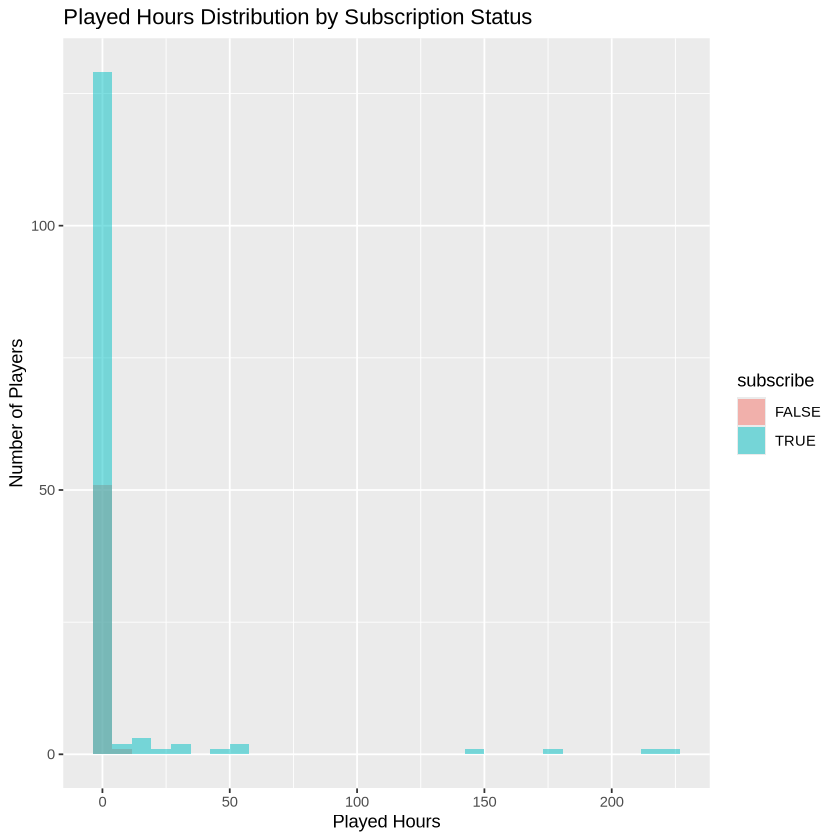

In [59]:
played_hours_plot <- ggplot(clean_player, aes(x = played_hours, fill = subscribe)) +
               geom_histogram(position = "identity", alpha = 0.5,bins = 30) +
               labs(title = "Played Hours Distribution by Subscription Status",x = "Played Hours", y = "Number of Players")
played_hours_plot

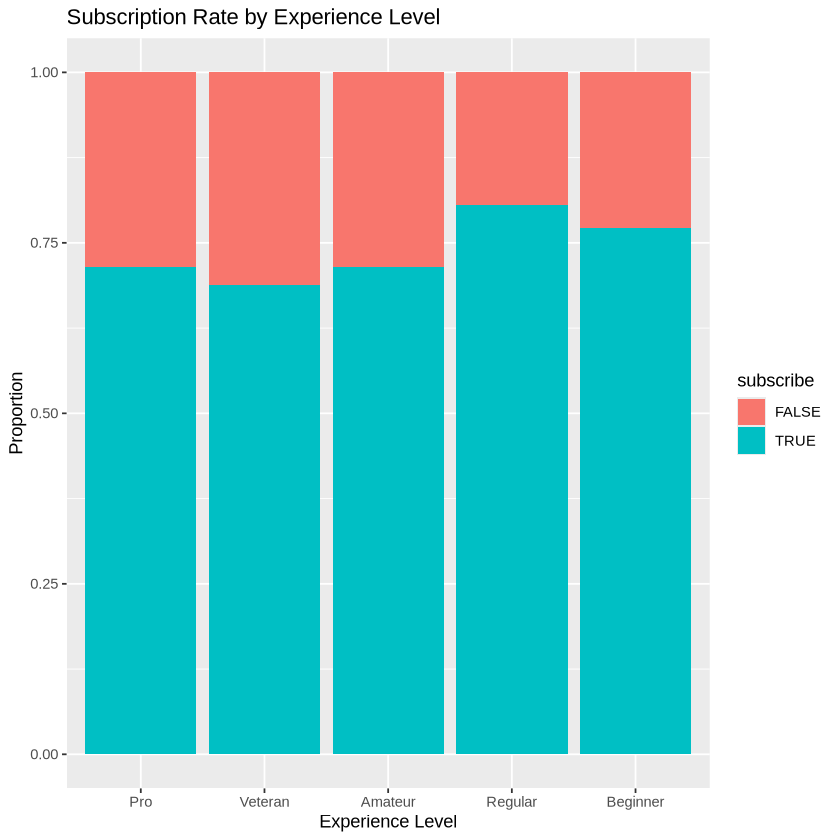

In [60]:
experience_plot <- ggplot(clean_player, aes(x = experience, fill = subscribe)) +
                   geom_bar(position = "fill") +
                   labs(title = "Subscription Rate by Experience Level",x = "Experience Level", y = "Proportion") 
experience_plot